In [8]:
%reset
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from xgboost import XGBClassifier

from sklearn.metrics import f1_score
from sklearn.tree import plot_tree

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
pd.set_option('display.precision', 3)
pd.set_option('display.max_colwidth', None)

# Opdracht 1: Exploratieve Data Analyse:
Gemaakt door de Majestueuze data-jokers:

&nbsp;&nbsp;&nbsp;&nbsp;Mark "Markolie20" Olieman <br>
&nbsp;&nbsp;&nbsp;&nbsp;Daan "Daan Eising" Eising <br>
&nbsp;&nbsp;&nbsp;&nbsp;Jesse "zdfgdfsg" van der Westen <br>

In [9]:
class EDA:
    def __init__(self, cols):
        # Define feature and target columns
        self.feature_cols = cols.difference(["p_id", "Outcome"])
        self.target_col = "Outcome"
        
        # Define which columns need to have zero values removed and which columns to replace the values with a KNN model
        self.col_to_drop_rows = ['BMI', 'Glucose', 'BloodPressure']
        self.col_to_validate = ["Insulin", "SkinThickness"]
        
        # Define objects to use
        self.df_handler = DfHandler()
        self.vis = Visualizer()
        
    def analyze_data(self, df):
        # Update the feature columns to match the dataframe
        self.analyze_cols = df.columns.difference(["p_id", "Outcome"])
        
        # Display the first 5 rows of the dataset to get a feel for how it looks
        display(df.head(5))
        
        # Display several stats of the dataset
        self.df_handler.display_stats(df, self.analyze_cols)
        
        # Display plots to show how the data is distributed in the feature columns
        self.vis.box_dist_plots(df, self.analyze_cols)
        
        # Display the correlation between the feature columns and the target column
        self.vis.corr_heatmap(self.df_handler.get_corr(df, self.analyze_cols, self.target_col))
    
    def clean_data(self, df, standardise=False, is_test_set=False):
        # Remove zero values from the previously defined columns
        df = self.df_handler.validate_and_drop_rows(df, self.col_to_drop_rows, self.col_to_validate, is_test=is_test_set)
        self.feature_cols = df.columns.difference(["p_id", "Outcome"])
        if standardise:
            df = self.df_handler.standardise_df(df, self.feature_cols)
        return df
        
        

In [10]:
class Visualizer:
    def box_dist_plots(self, df, cols):
        # Create a useable figure with subplots
        fig, axes = plt.subplots(len(cols), 2, figsize=(10, 15))
        fig.tight_layout()   
        
        # Create boxplots and histograms for every feature column defined
        for index, col in enumerate(cols):
            sns.boxplot(x=df[col], ax=axes[index, 0])    
            sns.histplot(x=df[col], ax=axes[index, 1])
            
            
    def corr_heatmap(self, corr_df):
        # Create a 1D heatmap of the correlation between feature columns and the target column 
        fig = plt.figure(figsize=(5, 5))
        sns.heatmap(corr_df, annot=True)
        
    

In [11]:
class DfHandler:
    def display_stats(self, df, cols):
        # Display the count, mean, std, min, 25%, 50%, 75%, max and dtype of the given dataframe and columns
        stats = df[cols].describe().T
        stats['dtype'] = [df[col].dtype for col in cols]
        display(stats)
    
    
    def get_corr(self, df, feature_cols, target_col):
        corr = pd.DataFrame(df[feature_cols].corrwith(df[target_col], method='pearson'))
        corr = corr.sort_values(0, ascending=False)
        return corr
            
    def standardise_df(self, df, cols):
        scaler = StandardScaler()
        df[cols] = pd.DataFrame(scaler.fit_transform(df[cols]),
                                                     index=df[cols].index,
                                                     columns=df[cols].columns)
        return df
    
    def validate_and_drop_rows(self, df, drop_cols, invalid_cols, is_test=False):
        # Add '_valid' columns for columns with too many invalid values where '_valid' gives whether the row had a valid value
        for col in invalid_cols:
            name = col + '_valid'
            df[name] = np.where(df[col] == 0, 0, 1)
        if not is_test:
            for col in drop_cols:
                df = df[df[col] != 0]
        return df
    

In [12]:
df = pd.read_csv("train_c.csv")
eda = EDA(df.columns)

## Data bekijken
De eerste stap die wij volgen is het bekijken van de verdelingen van de data, dit doen we door de basisstatistieken van alle feature kolommen te bekijken. 
we bekijken volgende statistieken:
- Gemiddelde
- Mediaan
- Standaard deviatie
- Min- en Maximum
- Eerste en derde kwartiel


Ook plotten wij van elke feature kolom de boxplot en een histogram om te kijken hoe de waardes verdeeld zijn in de dataset. Hiermee kunnen wij zien of er data in de dataset zit die wellicht niet juist is of dat er wellicht een hoop uitschieters zijn. 
Ook kunnen we zien of de data normaal verdeeld is of niet en of er eigenaardigheden zijn.

Als laatst gaan wij ook alvast kijken welke correlaties er zijn tussen de feature kolommen en de target kolom, hiermee kunnen we alvast een beeld schetsen over hoe de feature kolommen de target kolom kunnen beschrijven.

p_id  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0   668            6       98             58             33      190  34.0   
1   324            2      112             75             32        0  35.7   
2   624            2      108             64              0        0  30.8   
3   690            8      107             80              0        0  24.6   
4   473            7      136             90              0        0  29.9   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.430   43        0  
1                     0.148   21        0  
2                     0.158   21        0  
3                     0.856   34        0  
4                     0.210   50        0

count     mean      std     min     25%      50%  \
Age                       614.0   33.265   11.851  21.000  24.000   29.000   
BMI                       614.0   31.930    8.137   0.000  27.400   32.150   
BloodPressure             614.0   68.904   19.933   0.000  62.000   72.000   
DiabetesPedigreeFunction  614.0    0.468    0.329   0.078   0.238    0.365   
Glucose                   614.0  120.466   31.960   0.000  99.000  115.000   
Insulin                   614.0   81.251  116.947   0.000   0.000   27.000   
Pregnancies               614.0    3.809    3.376   0.000   1.000    3.000   
SkinThickness             614.0   20.456   16.063   0.000   0.000   23.000   

                              75%     max    dtype  
Age                        41.000   72.00    int64  
BMI                        36.500   67.10  float64  
BloodPressure              80.000  114.00    int64  
DiabetesPedigreeFunction    0.629    2.42  float64  
Glucose                   140.000  197.00    int64  
Insulin                   130.000  744.00    int64  
Pregnancies                 6.000   15.00    int64  
SkinThickness              32.000   99.00    int64

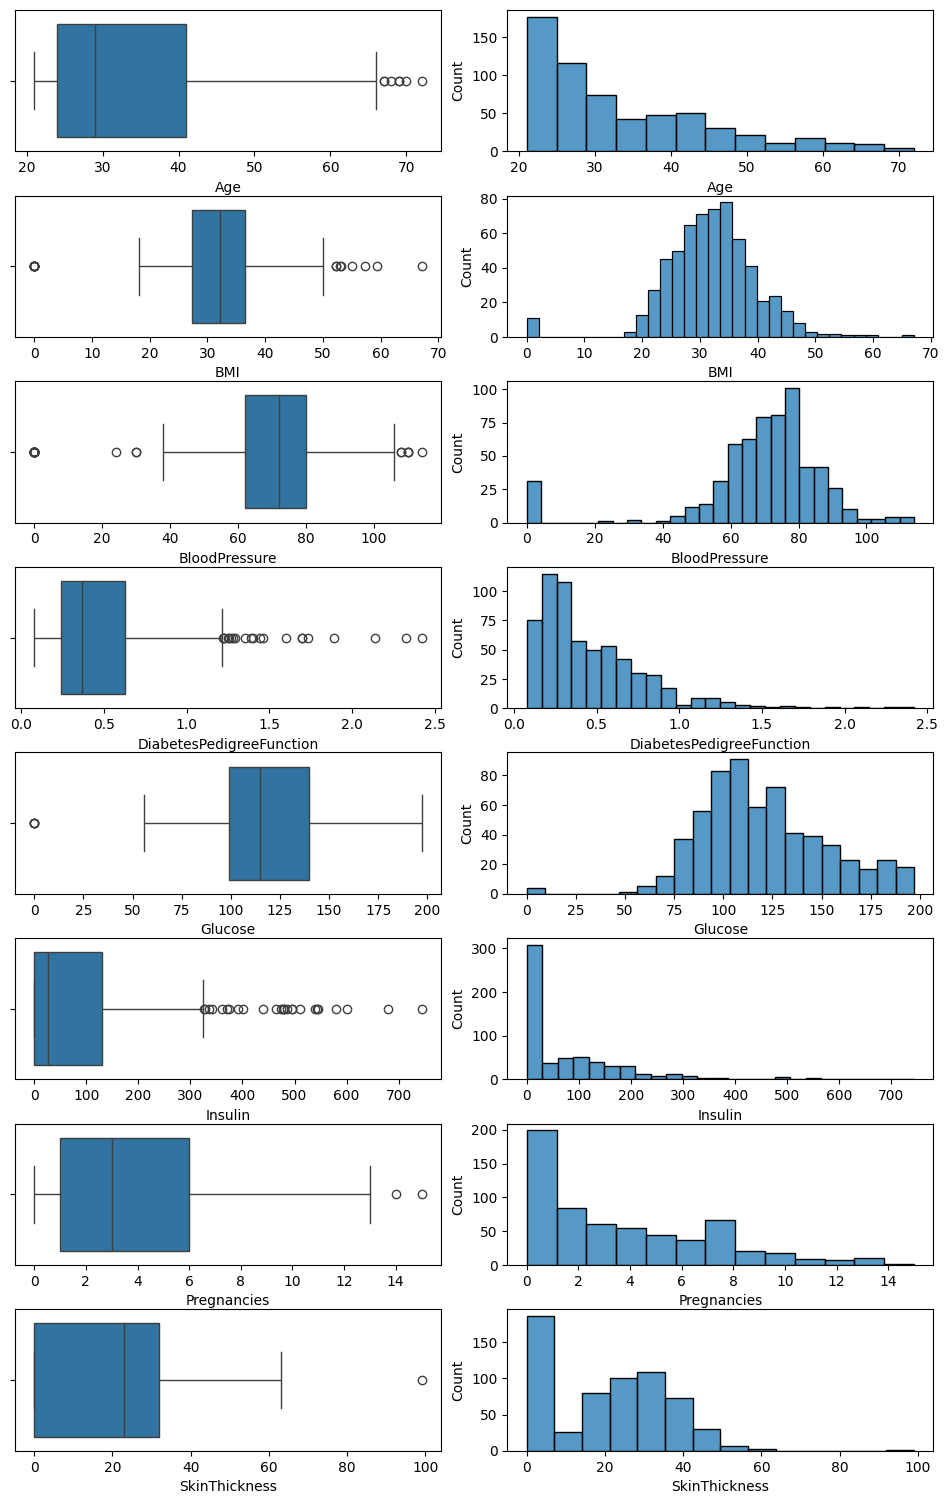

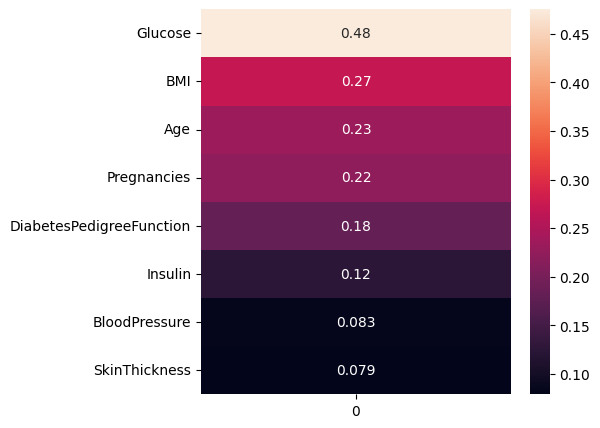

In [13]:
eda.analyze_data(df)

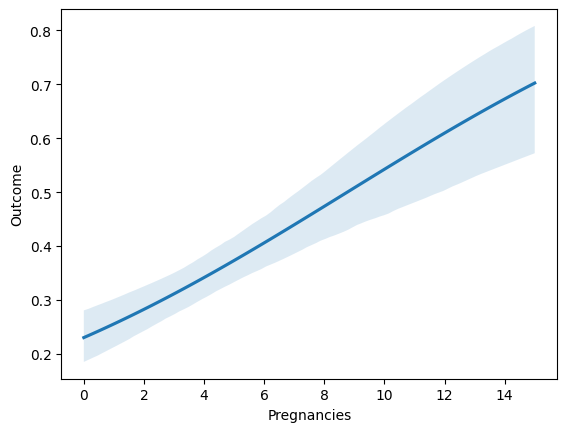

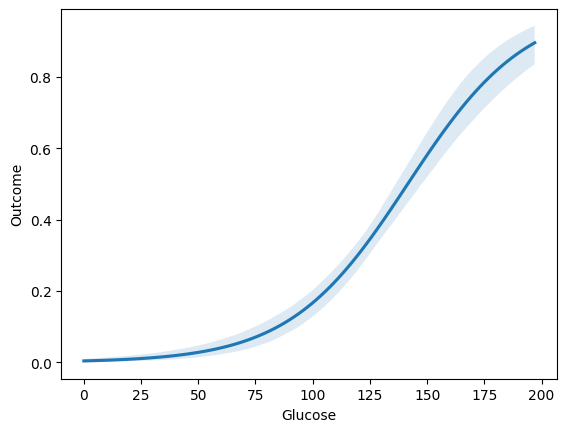

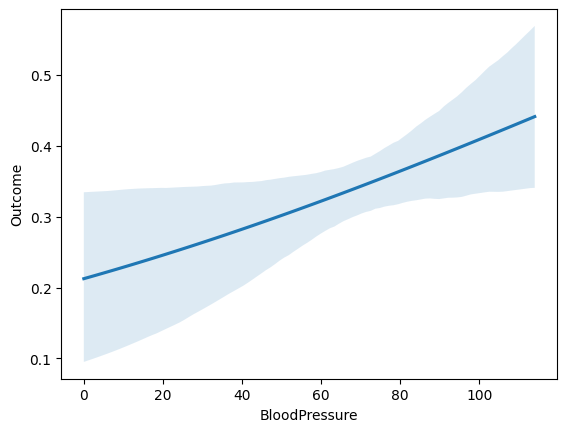

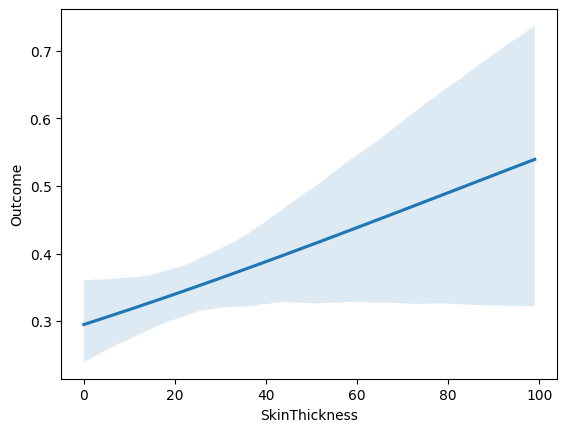

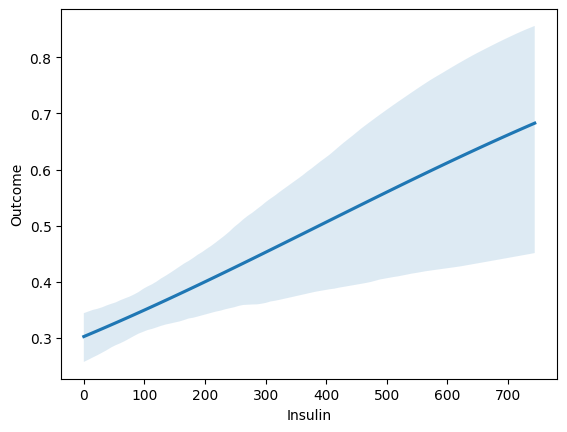

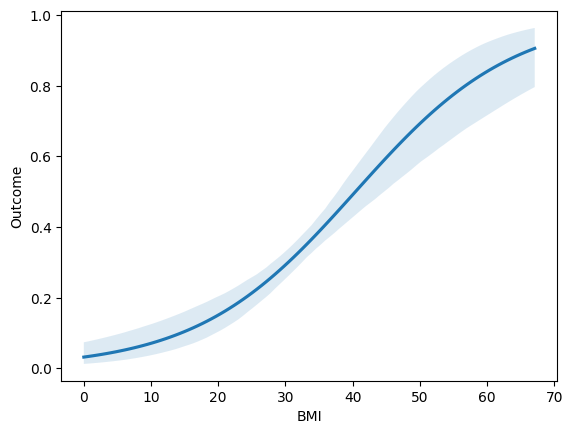

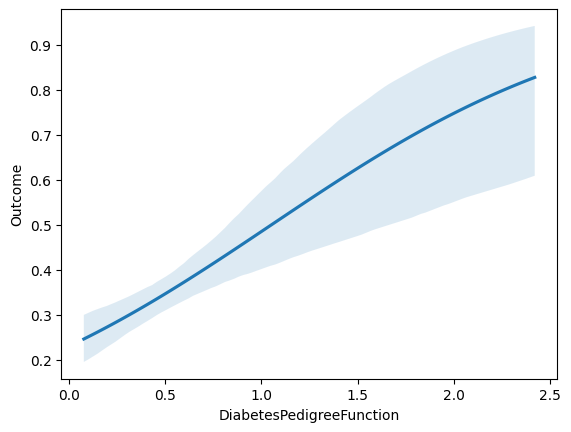

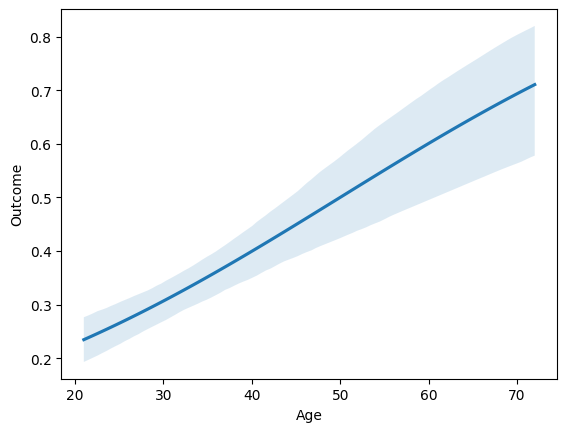

In [14]:
train_data = df
logistic_model = LogisticRegression()
logistic_model.fit(train_data[['Pregnancies']], train_data['Outcome'])
sns.regplot(x='Pregnancies', y='Outcome', data=train_data, logistic=True, scatter=False)
plt.show()

logistic_model.fit(train_data[['Glucose']], train_data['Outcome'])
sns.regplot(x='Glucose', y='Outcome', data=train_data, logistic=True, scatter=False)
plt.show()

logistic_model.fit(train_data[['BloodPressure']], train_data['Outcome'])
sns.regplot(x='BloodPressure', y='Outcome', data=train_data, logistic=True, scatter=False)
plt.show()

logistic_model.fit(train_data[['SkinThickness']], train_data['Outcome'])
sns.regplot(x='SkinThickness', y='Outcome', data=train_data, logistic=True, scatter=False)
plt.show()

logistic_model.fit(train_data[['Insulin']], train_data['Outcome'])
sns.regplot(x='Insulin', y='Outcome', data=train_data, logistic=True, scatter=False)
plt.show()

logistic_model.fit(train_data[['BMI']], train_data['Outcome'])
sns.regplot(x='BMI', y='Outcome', data=train_data, logistic=True, scatter=False)
plt.show()

logistic_model.fit(train_data[['DiabetesPedigreeFunction']], train_data['Outcome'])
sns.regplot(x='DiabetesPedigreeFunction', y='Outcome', data=train_data, logistic=True, scatter=False)
plt.show()

logistic_model.fit(train_data[['Age']], train_data['Outcome'])
sns.regplot(x='Age', y='Outcome', data=train_data, logistic=True, scatter=False)
plt.show()

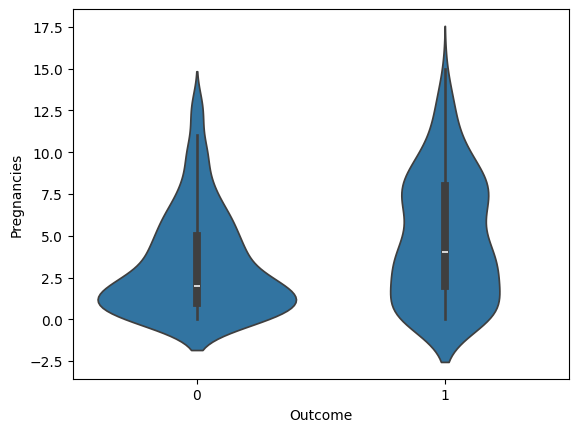

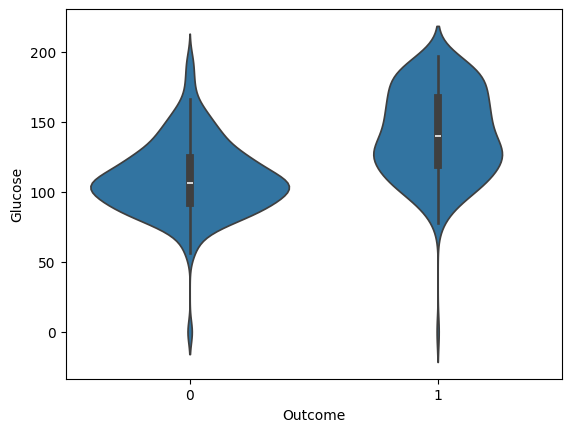

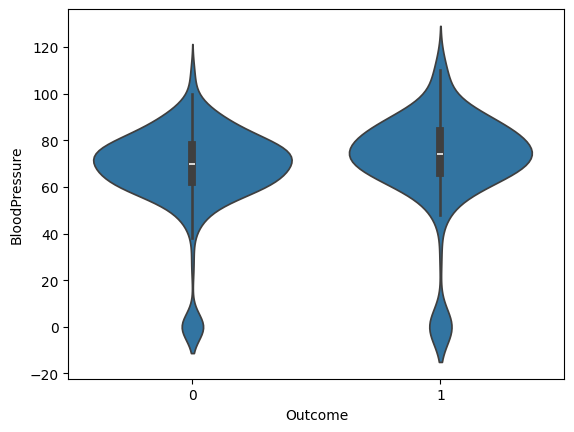

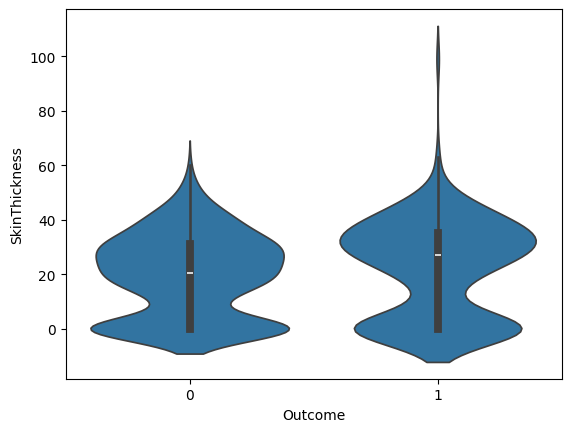

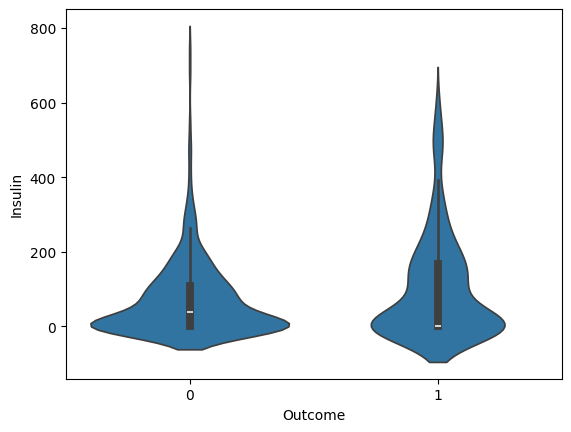

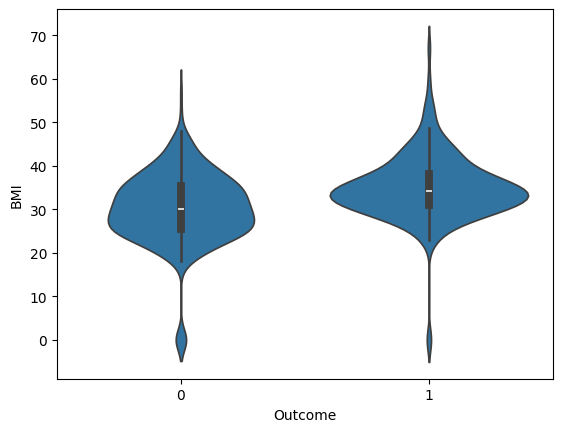

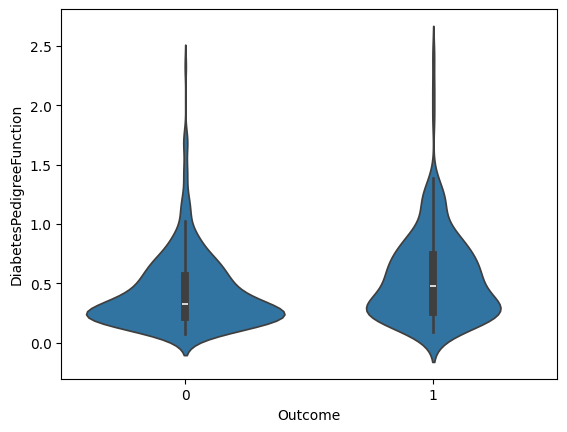

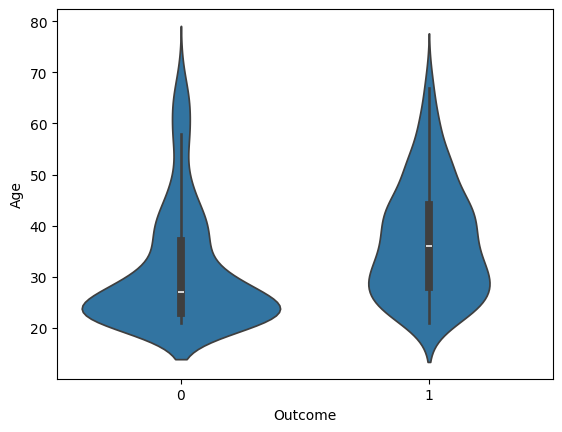

In [28]:
sns.violinplot(data=train_data, x="Outcome", y="Pregnancies")
plt.show()

sns.violinplot(data=train_data, x="Outcome", y="Glucose")
plt.show()

sns.violinplot(data=train_data, x="Outcome", y="BloodPressure")
plt.show()

sns.violinplot(data=train_data, x="Outcome", y="SkinThickness")
plt.show()

sns.violinplot(data=train_data, x="Outcome", y="Insulin")
plt.show()

sns.violinplot(data=train_data, x="Outcome", y="BMI")
plt.show()

sns.violinplot(data=train_data, x="Outcome", y="DiabetesPedigreeFunction")
plt.show()

sns.violinplot(data=train_data, x="Outcome", y="Age")
plt.show()

# Belangrijke bevindingen

In onze data-analyse hebben we het volgende vastgesteld:

- De correlatie tussen de onafhankelijke en afhankelijke variabelen.

- Bepaalde trends binnen de data door de data te visualiseren met behulp van een logistiek regressiemodel.

- **Zwangerschappen:** Hier zien we dat de voorspellingen minder nauwkeurig worden naarmate het aantal zwangerschappen hoger is.

- **Glucose:** Door de visualisatie van Glucose ten opzichte van de uitkomst en het bekijken van de correlatie tussen beide hebben we vastgesteld dat **Glucose** een zeer belangrijke variabele is, waarbij een hoge waarde een grotere kans geeft op een uitkomst van 1. We hebben ook opgemerkt dat de logistieke regressielijn vrij smal is en daarom nauwkeuriger is.

- **Bloeddruk:** De data vertoont een zeer hoge variatie, dus overpassing kan een probleem zijn. Bovendien heeft de data een lage correlatie met de uitkomst, dus het zal voor ons minder bruikbaar zijn dan sommige van de andere variabelen.

- **Huiddikte:** Huiddikte heeft de laagste correlatie met de uitkomst en lijkt in veel opzichten sterk op Bloeddruk, dus we zullen het op dezelfde manier behandelen.

- **Insuline:** De datapunten hebben een grote kans om een uitkomst van 1 te hebben als de datapunten uitschieters zijn. Het is ook belangrijk op te merken dat er veel nulwaarden zijn, vooral in de categorie met een uitkomst van 0.

- **BMI**

- We hebben verder patronen in de data uiteengezet door de data te visualiseren met behulp van vioolplots.

Het is zichtbaar in de visualisatie van Insuline, hier kunnen we duidelijk zien dat als het Insuline niveau een zeer hoge uitschieter is, er een zeer grote kans is dat de uitkomst 1 is.


## Voldoet de data aan de voorwaarden voor machine learning?
De data voldoet aan de voorwaarden aangezien de data:
- In een dataframe staat
- Geen lege waardes bevat
- In numerieke waardes is beschreven

## Data opschonen
Echter vinden wij dat de data nog schoongemaakt kan worden, dit vinden wij omdat in de boxplots te zien valt dat de volgende kolommen nog waardes van 0 bevatten die niet mogelijk zouden moeten zijn.
- Glucose
- BMI
- BloodPressure
- Insulin
- SkinThickness

Deze waardes met 0 gaan wij uit de data verwijderen.

Ook zien we dat er veel uitschieters zijn, wij vinden het belangrijk om deze data alsnog mee te nemen aangezien wij denken dat dit wellicht komt door omstandigheden die ook kunnen bijdragen aan diabetes.

p_id  Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
0   668        0.649   -0.768         -1.182          0.727    0.870  0.209   
1   324       -0.541   -0.312          0.198          0.664   -0.728  0.454   
2   624       -0.541   -0.442         -0.695         -1.357   -0.728 -0.253   
3   690        1.244   -0.475          0.605         -1.357   -0.728 -1.148   
4   473        0.947    0.469          1.417         -1.357   -0.728 -0.383   

   DiabetesPedigreeFunction    Age  Outcome  Insulin_valid  \
0                    -0.124  0.814        0          0.918   
1                    -0.980 -1.048        0         -1.089   
2                    -0.950 -1.048        0         -1.089   
3                     1.169  0.052        0         -1.089   
4                    -0.792  1.406        0         -1.089   

   SkinThickness_valid  
0                0.602  
1                0.602  
2               -1.661  
3               -1.661  
4               -1.661

count       mean    std    min    25%    50%    75%  \
Age                       575.0  2.719e-16  1.001 -1.048 -0.794 -0.371  0.645   
BMI                       575.0 -3.290e-16  1.001 -2.071 -0.715 -0.022  0.584   
BloodPressure             575.0  2.719e-16  1.001 -3.944 -0.695 -0.045  0.605   
DiabetesPedigreeFunction  575.0  1.406e-16  1.001 -1.193 -0.704 -0.303  0.500   
Glucose                   575.0  1.452e-16  1.001 -2.135 -0.703 -0.182  0.665   
Insulin                   575.0 -1.236e-17  1.001 -0.728 -0.728 -0.325  0.408   
Insulin_valid             575.0 -7.414e-17  1.001 -1.089 -1.089  0.918  0.918   
Pregnancies               575.0  6.488e-17  1.001 -1.137 -0.839 -0.244  0.649   
SkinThickness             575.0 -1.081e-16  1.001 -1.357 -1.357  0.159  0.727   
SkinThickness_valid       575.0 -8.032e-17  1.001 -1.661 -1.661  0.602  0.602   

                            max    dtype  
Age                       3.098  float64  
BMI                       4.986  float64  
BloodPressure             3.366  float64  
DiabetesPedigreeFunction  5.917  float64  
Glucose                   2.455  float64  
Insulin                   5.532  float64  
Insulin_valid             0.918  float64  
Pregnancies               3.328  float64  
SkinThickness             4.896  float64  
SkinThickness_valid       0.602  float64

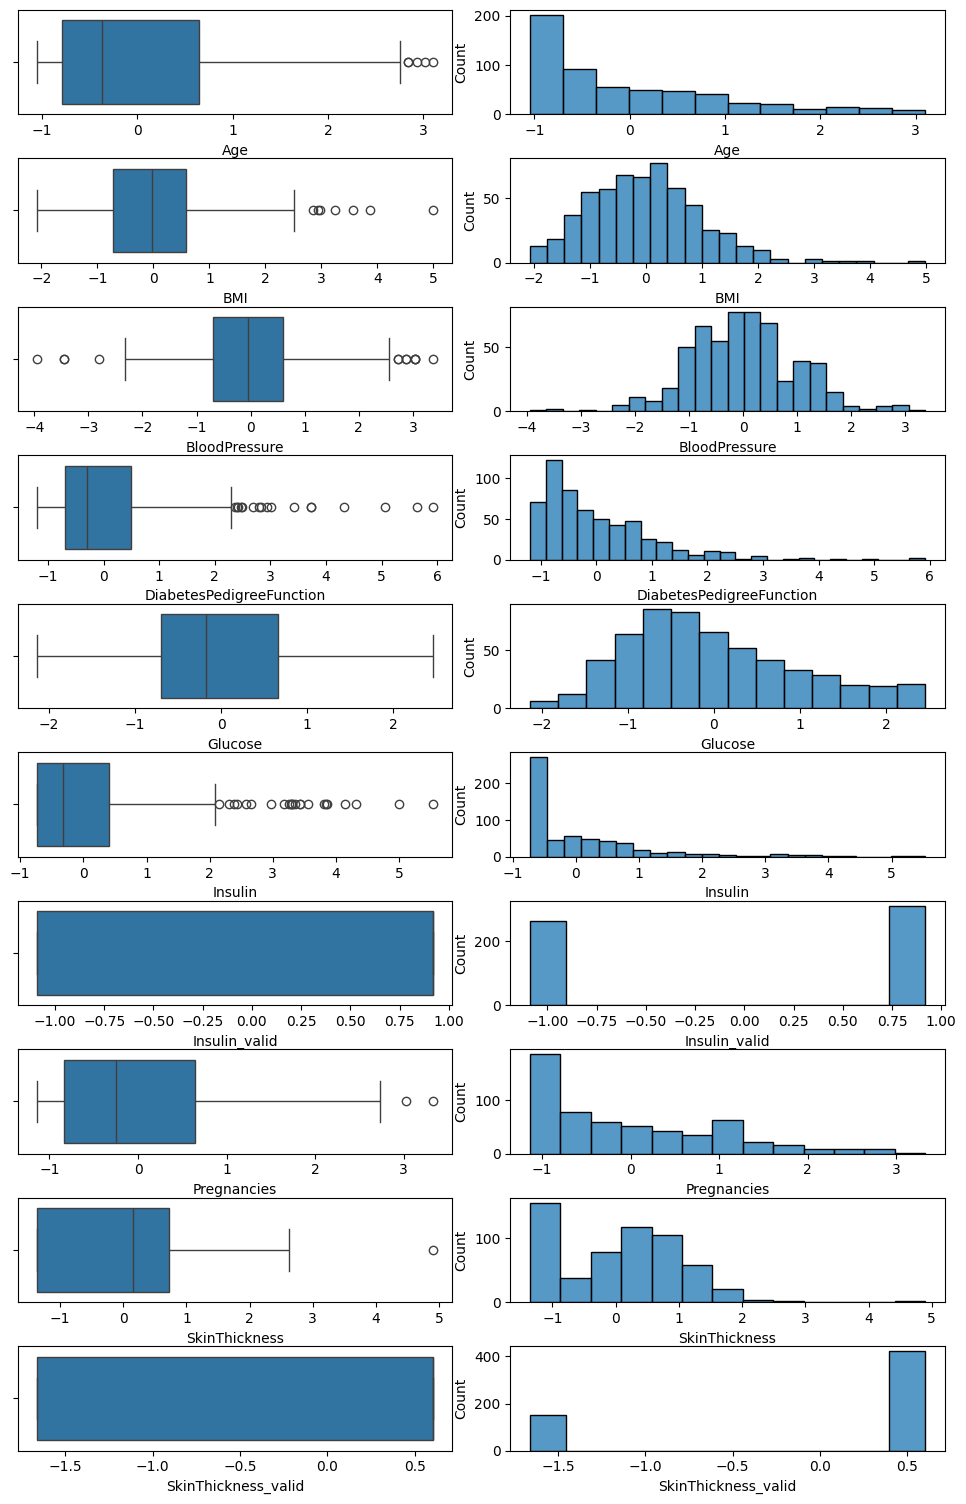

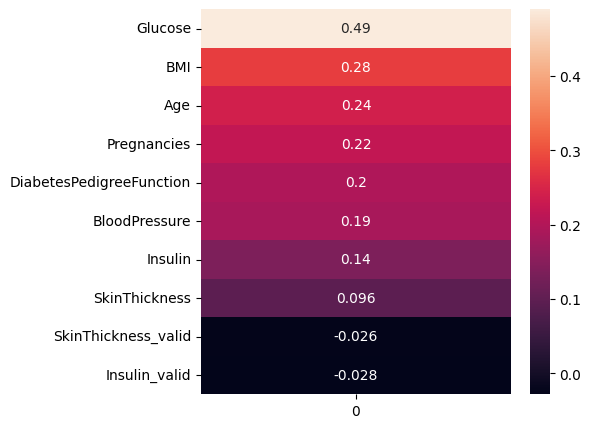

In [15]:
test_df = pd.read_csv('test_c.csv')
cleaned_df = eda.clean_data(df, standardise=True)
cleaned_test_df = eda.clean_data(test_df, standardise=True, is_test_set=True)
eda.analyze_data(cleaned_df)

## Opvallende dingen over opgeschoonde data
We zien dat de data van 614 rijen naar 312 rijen is gegaan, dit betekent dat wij een hoop rijen hebben verwijderd. Echter vinden wij dat dit beter is dan het alternatief, aangezien wij geen vertrouwen hebben goede modellen te kunnen maken als we geen goede data invoeren in de modellen. Zoals het beroemde gezegde "Garbage in = garbage out". 

We zien ook dat de correlaties omhoog zijn gegaan en dit is een goede indicatie dat de data die nu verwijderd is geen goede weergave gaf van de realiteit.

## Standaardiseren
Het staandaardiseren van data houdt in dat je de data schaalt op een manier dat het gemiddelde 0 wordt en de standaard deviatie 1. Om dit te doen wordt het aangeraden om data te hebben wat in een bell-curve valt en dat niet teveel outliers heeft. Ook is het alleen nuttig als feature kolommen ver uit elkaar liggen qua grootte van de waardes. Dit wordt gedaan om verschillende machine learning modellen beter te kunnen trainen als deze kijken naar afstand tussen datapunten om beslissingen te maken (zoals KNN of SVM).

Hoewel wij wel grote waardeverschillen hebben tussen de feature en KNN gebruiken om missende waardes in te vullen hebben wij toch besloten om niet de data te standaardiseren

# Evaluatie

### Deze opdracht heeft betrekking op een bepaalde vorm van machine learning. Welke vorm is dit? Licht het antwoord toe.


Tijdens de opdracht maken wij gebruik van de datasets genaamd "train_c.csv" en "test_c.csv".
Vanuit de opdracht omschrijving is te achterhalen dat we bij "train_c.csv" met een gelabelde dataset te maken hebben. De kolom "Outcome" is meegegeven en dit is in onze modellen dan ook de target kolom. Verder zijn alle overige kolommen ook gelabeld, dit zijn de feuture kolommen.
Ook wordt er gesproken over onze dataset "test_c.csv". Dit is de niet gelabelde dataset waarvoor wij uiteindelijk voorspellingen gaan maken aan de hand van onze modellen. 
https://brightspace.hhs.nl/d2l/le/lessons/56591/topics/663651

Door deze observaties kunnen wij ervan uit gaan dat wij te maken hebben met supervised machine learning. Hierbij worden modellen getraind met behulp van gelabelde datasets. Dit is data waar van te voren de juiste target uitkomst aan is gekoppeld. Met deze data gaat het model voorspellingen doen op niet gelabelde data.
https://www.breinstein.nl/de-digitale-wereld/een-introductie-in-machine-learning/
https://www.ibm.com/topics/supervised-learning




### Geef aan met welke “metrics”, voor deze vorm van machine learning, bepaalt kan worden hoe goed een model presteert. Toon de uitkomsten op deze metrics aan de hand van een zelf te kiezen machine learning algoritme.



Binnen supervised learning zijn er twee verschillende takken, zo is er regressie en classificatie. Bij regressie wordt aan de hand input data een waarde voorspelt. Bij classificatie wordt er voorspelt welk class label bij de input data hoort.
https://datasciencepartners.nl/supervised-learning/

In het geval van diabetes voorspellen is de waarde True of False. Dit geeft aan of iemand wel of niet diabetes heeft. Hier is er sprake van classificatie. Tijdens de opdracht zal er gewerkt worden met classificatie modellen.

Er zijn verschillende manieren om de prestaties van een classificatie model te presenteren, die manieren worden metrics genoemd. Voor classificatie gebruiken wij de volgende metrics:

Accuracy

Precision

Recall

F1-score

De uitkomsten van de bovenstaande metrics worden onder deze markdown cel getoond. Er is gebruik gemaakt van LogisticRegression voor de voorspellingen en een confusion matrix display om de uitkomsten te tonen.

Nu de eenheden duidelijk zijn zullen de verschillende metrics en hun formules hieronder worden toegelicht.

## Accuracy:
Bij accuracy wordt er gemeten hoe vaak het classificatie model een correcte voorspelling heeft gemaakt. Hierbij wordt de som van het aantal correcte voorspellingen gedeeld door de som van het totaal aantal voorspellingen.

$Accuracy = \frac{TP+TN}{TP+TN+FP+FN}$

https://www.analyticsvidhya.com/blog/2021/07/metrics-to-evaluate-your-classification-model-to-take-the-right-decisions/

## Precision:
Bij precison wordt er gemeten hoeveel correct voorspelde positieven er zijn ten opzichten van het totale aantal voorspelde positieven in de input data. Dit wordt gedaan door de True Positive te delen door de som van True Positive en False Positive. Wanneer het model goed preseteert zal het weinig False Positives bevatten en ligt de precision score dichter bij 1.0.

$Precision = \frac{TP}{TP+FP}$

## Recall:
Bij recall meten we het aantal True Positives gedeeld door de som van de True Positives en False Negatives. Hiermee worden alle correct voorspelde waarden gedeeld door alle  echte correcte waarden in de input data. Zo kan er gemeten worden hoe goed het model presteerd op het gebied van correcte voorspellingen maken aan de hand van de input data.


$Recall = \frac{TP}{TP+FN}$

https://towardsdatascience.com/metrics-to-evaluate-your-machine-learning-algorithm-f10ba6e38234

## F1 Score:
De F1 score wordt vaak gebruikt om de nauwkeurigheid van een classificatie model te beoordelen. Dit wordt vaak gedaan wanneer de dataset niet gebalanceerd is. Bij het berekenen van de F1 Score wordt zowel precision als recall gebruikt om het harmonische gemiddelde tussen de twee te berekenen. 

$F1 = \frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}$









# Uitleg eigen keuze
# F1-score keuze onderbouwen.

In [16]:
class Machine_learner:
    def __init__(self, df, test_set):
        self.df_handler = DfHandler()
        
        self.df = df
        self.test_df = test_set
        
        self.pred = pd.DataFrame(self.test_df['p_id'])
        
        self.feature_cols = df.columns.difference(["p_id", "Outcome"])
        self.target_col = "Outcome"
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.df[self.feature_cols],
                                                                                self.df[self.target_col],
                                                                                train_size = 0.2)
        
        
    def Lr(self):
        model = LogisticRegression()
        
        parameters = [{'solver' : ['newton-cg', 'lbfgs'],
                       'penalty' : ['l2'],
                       'max_iter' : [100, 150, 200, 500, 1000, 2500],
                       'C' : [0.001, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 1], 
                       'n_jobs': [-1]},
                      {'solver' : ['liblinear'],
                       'penalty' : ['l1', 'l2'],
                       'max_iter' : [100, 150, 200, 500, 1000, 2500],
                       'C' : [0.001, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 1]}]
        clf = GridSearchCV(model, parameters, verbose=1)
        return clf
    
    def decision_tree(self):
        model = DecisionTreeClassifier()
        
        parameters = {'criterion' : ['gini', 'entropy'],
                      'max_depth': range(3, 8),
                      'min_samples_split': [4, 5, 6],
                      'min_samples_leaf': [4, 5, 6]}
        
        clf = GridSearchCV(model, parameters, verbose=1)
        return clf
    
    def random_forest(self):
        model = RandomForestClassifier()
        
        parameters = {'n_estimators': range(50, 100, 25),
                      'criterion': ['gini', 'entropy'],
                      'max_depth': range(2, 4),
                      'min_samples_split': [4, 5, 6],
                      'min_samples_leaf': [4, 5, 6],
                      'n_jobs': [-1]}
        
        clf = GridSearchCV(model, parameters, verbose=1)
        return clf
    
    def gradient_boosting(self):
        model = GradientBoostingClassifier()
        
        parameters = {'n_estimators': range(5, 30, 5),
                      'learning_rate': np.arange(0.05, 0.15, 0.05),
                      'min_samples_split': [4, 5, 6],
                      'min_samples_leaf': [4, 5, 6]}
        
        clf = GridSearchCV(model, parameters, verbose=1)
        return clf
    
    def ada_boosting(self):
        model = AdaBoostClassifier()
        
        parameters = {'n_estimators': range(10, 25, 5),
                      'learning_rate': np.arange(0.5, 1, 0.1)}
        
        clf = GridSearchCV(model, parameters, verbose=1)
        return clf
    
    def svm(self):
        model = SVC()
        
        parameters = {'C': [0.1, 1, 10],
                      'kernel': ['rbf', 'poly'],
                      'gamma': np.arange(0.6, 1.4, 0.1),
                      'degree': [2, 3, 4]}
        
        clf = GridSearchCV(model, parameters, verbose=1)
        return clf
    
    def xgboost(self):
        model = XGBClassifier()
        
        parameters = {'n_jobs': [-1],
                      'n_estimators': range(5, 30, 5),
                      'max_depth': range(2, 3),
                      'max_leaves': range(2, 4),
                      'learning_rate': np.arange(0.2, 0.4, 0.1),
                      'max_delta_step': np.arange(0.2, 0.4, 0.1),
                      'gamma': np.arange(0.2, 1, .1)}
        
        clf = GridSearchCV(model, parameters, verbose=1)
        return clf
    
    def fit(self, clf):
        clf.fit(self.X_train, self.y_train)
        
        train_y_pred = clf.predict(self.X_train)
        test_y_pred = clf.predict(self.X_test)
        f1_train = f1_score(self.y_train, train_y_pred)
        f1_test = f1_score(self.y_test, test_y_pred)

        display(f'The model with the best parameters that we tested is: {clf.best_estimator_}')
        display(f'Training F1 score: {round(f1_train, 3)}')
        display(f'Testing F1 score: {round(f1_test, 3)}')
        return clf
    
    def make_predictions(self, clf, name):
        clf = ml.fit(clf)
        self.pred['Outcome'] = clf.predict(test_df[self.feature_cols])
        self.pred.to_csv(name + '_prediction.csv', index=False)


In [17]:
ml = Machine_learner(cleaned_df, cleaned_test_df)

# Logistic Regression:
## uitleg model:
Logistic regression is een supervised machine learning model dat wordt gebruikt voor het voorspellen van een binaire uitkomst. Dit betekent dat het model een 0 of 1 voorspelt, is de uitkomst waar of niet waar, True of False.

Logistic regression probeert een lijn(decision boundary) te trekken door de data, om dit te verdelen. Aan de ene kant van de decision boundary wordt de voorspelling 1 en aan de andere kant wordt het 0. Deze decision boundary wordt gevormd door alle features een gewicht mee te geven en deze bij elkaar op te tellen in een formule en een beginpunt toe te voegen. 

Dit is dus praktisch gezien een N-dimensionale lineaire functie met N als hoeveelheid features in de dataset.

De hierboven beschreven decision boundary ziet er als volgt uit:<br>
$z = w_1\cdot x_1+w_2\cdot x_2+ w_3\cdot x_3+\ldots+w_n\cdot x_n + a = 0$<br>
met:<br>
$z = de\ decision\ boundary$<br>
$x_0,x_1,\ldots,x_n = de\ waardes\ van\ de\ features\ om\ de\ decision\ boundary\ 0\ te\ laten\ zijn$<br>
$w_0,w_1,\ldots,w_n = coefficienten\ bepaald\ door\ het\ model$<br>
$a = beginpunt\ bepaald\ door\ het\ model$<br>

Hieronder een voorbeeld van hoe een decision boundary eruit kan zien van een getrained model voor de features $x_1\ en\ x_2$:
![decision boundary](https://scipython.com/static/media/uploads/blog/logistic_regression/decision-boundary.png)

Maar als je deze formule gebruikt kan je nog niet bepalen of een waarde 0 of 1 moet worden, Daarom wordt deze functie in een sigmoid functie gezet. Een sigmoid functie is een functie die eruit ziet als s-curve, aan de linkerkant van de y-as ligt deze functie erg dicht bij y=0 en stijgt dan steeds sneller naarmate x=0 nadert. Dan kruist de functie y=0.5 bij x=0 en vlakt dan langzaam weer af wanneer de lijn y=1 nadert. Je kan de uitkomst van de lijn zien als zekerheid van het model of de waarde als 1 voorspelt zou moeten worden. Als de zekerheid boven de 0.5 ligt dan voorspelt het model 1 en als het onder de 0.5 ligt dan voorspelt het model 0. Als een punt precies op de decision boundary ligt zal de voorspelde waarde dus ook 0.5 zijn.

De hierboven beschreven sigmoid functie ziet er als volgt uit:<br>
$\hat{y} = \frac{1}{1+e^{-z}}$<br>
met:<br>
$\hat{y} = de\ voorspelde\ zekerheid$<br>
$e = euler's\ nummer\ = 2.718...$<br>
$z = de\ formule\ van\ de\ decision\ boundary$<br>


Hier een visualisatie van de sigmoid functie:
![sigmoid functie](https://upload.wikimedia.org/wikipedia/commons/thumb/8/88/Logistic-curve.svg/800px-Logistic-curve.svg.png)

En als je hier dan de door het model gegenereerde waardes van de coefficienten en het beginpunt invult in de formule van de decision boundary en de waardes van de features van de rij uit je dataset die je wilt voorspellen dan komt er een waarde tussen de 0 en 1 uit. Waarbij alle waardes tussen 0 en 0.5 geclassifiseerd worden als 0 en alle waardes tussen 0.5 en 1 geclassifiseerd worden als 1.
## loss function:
Om te kijken hoe goed het model werkt wordt de loss functie toegepast. Deze functie neemt de echte waarde en de voorspelde zekerheid en gebruikt deze in een formule om zo te kijken hoe goed het model is. Dit kan op verschillende manieren gedaan worden, maar bij logistic regression is het gebruikelijk om de log loss functie toe te passen.

De hierboven genoemde log loss functie ziet er als volgt uit:<br>
$-\frac{1}{n}\displaystyle\sum_{i=1}^{n}(y_i\cdot log(\hat{y_i})+(1-y_i)\cdot log(1-\hat{y_i}))$<br>
Met:<br>
$n = Hoeveelheid\ voorspelde\ datapunten$<br>
$y_i = De\ echte\ waarde\ van\ het\ i^{de}\ datapunt$<br>
$\hat{y_i} = De\ voorspelde\ zekerheid\ van\ het\ i^{de}\ datapunt$<br>

Deze formule is eigenlijk 2 formules in 1.

zo wordt bij een echte waarde van 0 alleen de rechterzijde van de formule gebruikt aangezien:
$-\frac{1}{n}\displaystyle\sum_{i=1}^{n}(0\cdot log(\hat{y_i})+(1-0)\cdot log(1-\hat{y_i})) = -\frac{1}{n}\displaystyle\sum_{i=1}^{n}(log(1-\hat{y_i}))$<br>
En bij een echte waarde van 1 wordt alleen de linkerzijde gebruikt aangezien:<br>
$-\frac{1}{n}\displaystyle\sum_{i=1}^{n}(1\cdot log(\hat{y_i})+(1-1)\cdot log(1-\hat{y_i})) = -\frac{1}{n}\displaystyle\sum_{i=1}^{n}(log(\hat{y_i}))$<br>
![log loss](https://editor.analyticsvidhya.com/uploads/661483.png)
De grafiek van de log loss functie is hierboven weergegeven met $\hat{y_i}=h(x)$.

Je kan in de visualisatie goed zien dat de loss steeds verder toeneemt naarmate de voorspelde waarde verder van de echte waarde ligt. Ook kan je goed zien waarom log loss zo goed werkt voor binaire classificatie aangezien het werkt voor 0 en 1 tegelijk.

## gradient descent:
Om de hierboven beschreven loss zo klein mogelijk te maken moeten de coefficienten en het beginpunt van de decision boundary worden bepaald. Dit gebeurd met een proces genaamd gradient descent, gradient descent probeert de loss naar een minimum te brengen voor alle coefficienten.

Dit gebeurt door de helling te berekenen van de loss functie tegenover de leerbare coefficient. als de helling namelijk 0 is betekent dit dat we een minimum hebben bereikt.

De formule van het updaten van de coefficient ziet er als volgt uit:<br>
$w_{i_{nieuw}} = w_{i_{oud}}-\alpha \cdot \frac{\delta Loss}{\delta w}$<br>
Met:<br>
$w_{i_{nieuw}} = De\ nieuwe\ waarde\ voor\ de\ i^{de}\ coefficient\ w$<br>
$w_{i_{oud}} = De\ oude\ waarde\ voor\ de\ i^{de}\ coefficient\ w$<br>
$\alpha = de\ learning\ rate$<br>
$\frac{\delta Loss}{\delta w} = De\ coefficient\ van\ de\ helling\ van\ de\ loss\ tegenover\ w$<br>

Gradient descent blijft de coefficienten updaten tot deze onder een bepaalde threshold komen, 0 bereiken of als de maximale hoeveelheid updates(stappen) bereikt is. Gradient descent pakt een punt en kijkt hoe groot de helling is, vervolgens wordt er een stap gezet proportioneel aan de grote van de coefficient van de helling. Al is er dus een stijle helling die een daling ondervind naar een richting word er ook een grote stap naar die richting gezet om daar vervolgens te kijken hoe de helling daar is. Dit zou moeten leiden naar een punt waar de helling minder stijl is. Dus als er vervolgens een kleinere helling wordt gevonden betekent dit dat we dichterbij de optimale waarde van w zijn en wordt er maar een kleine stap gezet richting de daling van de helling.

Dit ziet gevisualiseerd als volgt uit:
![gradient descent](https://www.researchgate.net/profile/Kamyab-Keshtkar/publication/355179987/figure/fig6/AS:1078354740555780@1634111213342/A-schematic-representation-of-the-gradient-descent-algorithm-The-gradient-of-the-loss.png)

Ook bevat de formule de term $\alpha$, dit is de learning rate. De learning rate is een hyperparameter die gebruikt kan worden om te beinvloeden hoe groot de stappen zijn die gezet worden door de gradient descent. Bij een kleine learning rate worden er dus kleine stappen gezet, hierdoor duurt het langer om bij het minimum te komen, maar het kan hierdoor ook nauwkeuriger worden. Bij een grote learning rate worden er dus grote stappen gezet, maar is hierdoor dus ook minder nauwkeurig. Het is van belang dat er de learning rate zo gekozen wordt dat de training in realistische tijd kan worden uitgevoerd. Ook is het gevaarlijk om te precies het minimum te willen bereiken met de trainingsdata, dit zorgt er namelijk voor dat je model overfit en dat kan leiden tot een geweldige score bij je trainingsdata maar een slechte score bij je test data.

Hieronder een visualisatie van de learning rate met betreffing tot hoe het de stappen van gradient descent beinvloeden:
![learning rate](https://builtin.com/sites/www.builtin.com/files/styles/ckeditor_optimize/public/inline-images/national/gradient-descent-learning-rate.png)
## regularisatie:
Regularisatie is een manier om overfitting van een model tegen te gaan, dit wordt gedaan door een penalty gebaseerd op de coefficienten van de decision boundary toe te voegen aan de loss functie. Hierdoor worden grote coefficienten afgestraft en wordt het model beter in generaliseren.

Er zijn 2 types regularizatie die vaak worden toegepast, namelijk L1/Lasso regularizatie en L2/Ridge regularizatie:

De formules hiervoor zien er als volgt uit:<br>
$L1 = \frac{1}{c}\displaystyle\sum_{i=1}^{n}|w_i|$<br>
$L2 = \frac{1}{c}\displaystyle\sum_{i=1}^{n}w_i^2$<br>
Met:<br>
$c = Een\ hyperparameter\ die\ de\ sterkte\ van\ de\ regularizatie\ beinvloed$<br>
$n = Hoeveelheid\ coefficienten$<br>
$w_i = De\ i^{de}\ coefficient$<br>

Zoals hier te zien wordt er bij L1 simpelweg de som van de absolute waarde van de coefficienten toegevoegd en bij L2 de som van het kwadraat van de coefficienten. 

Door het verschil in de formules van L1 en L2 zijn er ook een aantal verschillen in het gebruik van de verschillende regularizaties. 

Zo kan L1 worden gebruikt voor feature selecting aangezien het mogelijk is voor L1 om coefficienten naar 0 te kunnen brengen. Zodra een coefficiente van een feature op 0 staat wordt deze feature dus niet meer meegenomen in de voorspelling. Dit komt doordat de helling van de grafiek van L1 regularisatie bij 0 undefined is wat zorgt dat de gradient descent voor die feature ophoudt. Terwijl bij L2 regularisatie de helling bij de waarde 0 voor de coefficient simpelweg ook 0 is dus zal de gradient descent gewoon doorgaan en is het heel onwaarschijnlijk dat de waarde eindigt op 0.

In de grafiek hieronder zie je hoe de helling tegelijk 1 en -1 is bij een coefficient van 0 wat zorgt dat de gradient descent stopt met werken en de feature op 0 blijft staan.
![feature selecting with L1](https://miro.medium.com/v2/resize:fit:1400/1*etUdoAT3P51qjMiadDRHhQ.gif)

Ook valt te zien dat L1 regularisatie de coefficient meer afstraft als deze zich tussen -1 en 1 bevind terwijl L2 regularisatie de coefficient meer afstraft als deze groter is dan 1 of kleiner dan -1.

## Toepassing en tuning:
Het tunen van de hyperparameters doen wij doormiddel van GridSearchCV uit de sklearn library, deze functie fit de data doormiddel van cross-validation en kijkt welke hyperparameters het beste werken.
De parameters die wij testen zijn:
- solver
- penalty
- maximum iterations
- c

Wij hebben hierboven uitgelegd wat de basis is van het optimaliseren van de coefficienten doormiddel van gradient descent. Maar in de realiteit zijn er veel kleine(en soms grote) verschillen in hoe dit daadwerkelijk geimplementeerd word(soms met andere methodes dan gradient descent). De solver parameter is een manier om te kiezen tussen de manieren die worden aangeboden in de sklearn library.

Ook hebben wij regularisatie uitgelegd hierboven, de parameter penalty geeft aan welke regularisatie er gebruikt moet worden. Niet alle solvers zijn compatibel met alle regularisaties, maar toch testen wij alle mogelijke combinaties met de solvers die wij gekozen hebben en de regularisatie die hierbij toegepast kunnen worden. Dit om overfitting zoveel mogelijk tegen te gaan.

Maximum iterations geeft aan na hoeveel stappen de solver moet stoppen met het optimaliseren van de coefficienten, dit om overfitting tegen te gaan. Zoals hierboven ook al beschreven bij gradient descent onder learning rate is het van belang niet het perfecte minimum te bereiken voor je training data aangezien het waarschijnlijk is dat je model dan overfit is en niet goed kan generaliseren op nieuwe data. Door maximale iterations aan te passen kan de solver niet oneindig doorgaan om het minimum te zoeken en zal het model dus minder overfit raken.

c is in dit geval dezelfde c als gebruikt in de regularisatie formule, door het aanpassen van deze c kunnen wij controleren hoe sterk de regularisatie is en daarmee kunnen we proberen het model mooi te laten generaliseren zonder te overfitten.

Ook zie je n_jobs staan in de parameters van GridSearchCV, dit heeft verder geen impact op het model, maar is alleen om te zorgen dat alle cores van de processor worden gebruikt om zo sneller te kunnen trainen.

Bij het tunen hebben wij vele waardes geprobeerd en gekeken of deze voor goede resultaten zorgen. De waardes die overgebleven zijn, zijn de waardes die zorgen dat het model in ieder geval niet teveel overfit. Dit hebben wij bepaald door de F1 score van de trainingsdata en de testdata te vergelijken en te zorgen dat hier een niet al te hoog verschil in zit.

In [18]:
ml.make_predictions(ml.Lr(), 'lr')

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


"The model with the best parameters that we tested is: LogisticRegression(C=1, n_jobs=-1, solver='newton-cg')"

'Training F1 score: 0.435'

'Testing F1 score: 0.381'

# Decision Tree:
## uitleg model:
**Root node:** Het allereerste blad van een boom.

**Decision node/internal node:** Een beslissingsknooppunt is een knooppunt in de boom waar een beslissing wordt genomen op basis van bepaalde criteria om te bepalen welke kant de boom moet opgaan.

**Leaf nodes/terminal node:** Een bladknooppunt wordt gebruikt als laatste knooppunt in de boom om de uiteindelijke beslissing weer te geven.

**Parent/child node:** Een ouderknooppunt is het knooppunt dat zich splitst in kindknooppunten.

**Entropy:** Entropy is een maat voor de mate van willekeur of onzekerheid. Lage entropie betekent dat de beslissing zekerder is.

Entropy-formule: Entropy = Σ(i=1)^n [-p_i * log2(p_i)]

waarbij:
- `n` het aantal uitkomsten is.
- `p_i` de waarschijnlijkheid is van de `i`-de uitkomst.

**Voorbeeld:**
Als je 3 * 1 hebt en 5 * 0, dan heb je 3/8 * P_1 en 5/8 * P_0. De entropie van dat blad is dan:
-3/8 * log2(3/8) - 5/8 * log2(5/8) = 0.954

Dit zou dus een hoge entropie hebben, wat klopt omdat het erg willekeurig is.

Als je 0 * 1 hebt en 8 * 0, dan heb je 0/8 * 1 en 8/8 * 0. De entropie van dat blad is dan:
-0 * log2(0) - 1 * log2(1) = 0

Dus dan is er geen willekeur meer.

**Information Gain:** Information gain is het verschil tussen de entropie van het beslissingsknooppunt en de knooppunten die daaruit voortkomen.

Information gain-formule:

Information Gain = Entropy_parent - Σ(i=1)^n [(samples_i / samples_parent) * Entropy_i]


**Gini impurity:** Gini-impurity geeft aan wat de kans is dat een nieuwe sample verkeerd wordt geclassificeerd door het knooppunt waarvan de Gini-impurity wordt berekend.

Gini impurity-formule:
Gini Impurity = Σ(i=1)^n [p_i * (1 - p_i)]
waarbij `p_i` de kans is op de `i`-de uitkomst.

**Misclassificatiefout:** De misclassificatiefout is het deel van de samples dat verkeerd wordt geclassificeerd.

Misclassificatiefout-formule:Misclassificatiefout = (Aantal onjuist geclassificeerde samples) / (Totaal aantal samples)

## splitsingscriteria:

# Toepassing en Tuning
Bij het toepassen van de decision tree in dit project hebben we gebruikgemaakt van twee parameters:

- **Criterion:** We hebben gekozen voor "gini" en "entropy" als criteria. Dit helpt de kans op verkeerd geclassificeerde samples te verkleinen.

- **Max_depth:** We hebben een breed bereik gekozen voor max_depth, namelijk van 4 tot 11. Dit stelt ons in staat om een balans te vinden tussen onderfitting en overfitting.

# Pruning
Om overfitting te voorkomen, hebben we pruning toegepast. Pruning houdt in dat onnodige takken worden verwijderd. We hebben condities gekozen op basis van het aantal samples in een blad en/of de diepte van de tak.

Na het snoeien hebben we de prestaties van het nieuwe model geëvalueerd, meestal met behulp van een onafhankelijke dataset of crossvalidatie.


In [29]:
ml.make_predictions(ml.decision_tree(), 'decision_tree')

Fitting 5 folds for each of 90 candidates, totalling 450 fits


"The model with the best parameters that we tested is: DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=4,\n                       min_samples_split=4)"

'Training F1 score: 0.537'

'Testing F1 score: 0.272'

# Random Forest:
## uitleg model:

Random forest is een ensamle-algoritme dat bestaat uit meerdere decision trees.
Dit model is op meerdere manieren te gerbruiken, als classificatie nodig is gebruik het model iedere aparte boom en diens voorspelling als een ‘vote’. De klasse met de meeste votes word gebruikt.




Bij regressive problemen gebruik de forest het gemiddelde van alle bomen als resultaat.

Bij het maken van een random forest word gebruik gemaakt van een concept genaamd bagging, hierbij gebruik je steeds een willekeurige subset van de data om te trainen. Dit blijft gebeuren bij het splitsen van knooppunten om zo overfitting tegen te gaan.

## performance en pruning:
Prestaties en Voordelen

Bij het bouwen van een Random Forest-model zijn er enkele belangrijke voordelen om in gedachten te houden:
Minder behoefte aan hyperparameter-tuning: Random Forest-modellen zijn van nature robuust en vereisen meestal minder fijnafstemming van hyperparameters.
Robuustheid tegen ruis: Random Forest kan goed omgaan met ruis en uitschieters in gegevens, waardoor het geschikt is voor real-world datasets.
Feature importance: Het model biedt inzicht in de belangrijkste kenmerken die bijdragen aan de voorspellingen.
Hoge voorspellende nauwkeurigheid: Door de aggregatie van meerdere bomen levert Random Forest over het algemeen betrouwbare en nauwkeurige voorspellingen op.
Pruning (Snoeien)

Bij het snoeien van een Random Forest is het over het algemeen niet nodig om parameters zoals max_depth of min_samples_leaf aan te passen. Dit komt doordat Random Forests van nature al redelijk robuust zijn tegen overfitting. Dit is te danken aan de aggregatie van meerdere verschillende bomen en het gebruik van willekeurige selectie van functies tijdens het trainen.
## toepassing en tuning:
Bij het toepassen van Random Forest-modellen in ons project hebben we de volgende parameters gebruikt:
n_estimators: Dit is het aantal bomen in de forest. We hebben verschillende waarden getest, variërend van vijftig tot tweehonderd. Deze parameter beïnvloedt het evenwicht tussen modelcomplexiteit en prestaties.
criterion: Hiermee kan worden ingesteld welke criteria een knooppunt moet gebruiken om gepruned te worden. We hebben zowel 'gini' als 'entropy' getest, omdat deze criteria mogelijk invloed kunnen hebben op de prestaties.
max_depth: We hebben verschillende waarden getest, waaronder 'None', wat betekent dat de diepte automatisch wordt bepaald. We hebben een breed scala aan diepten onderzocht om een optimale balans te vinden tussen modelcomplexiteit, prestaties en het voorkomen van over- of onderfitting.

In [20]:
ml.make_predictions(ml.random_forest(), 'random_forest')

Fitting 5 folds for each of 72 candidates, totalling 360 fits


"The model with the best parameters that we tested is: RandomForestClassifier(criterion='entropy', max_depth=2, min_samples_leaf=6,\n                       min_samples_split=4, n_estimators=75, n_jobs=-1)"

'Training F1 score: 0.067'

'Testing F1 score: 0.036'


# Gradient Boosting:

In de wereld van machine learning is gradient boosting een veel gebruikte techniek voor regressie/classificatieproblemen. Het levert een voorspellingsmodel in de vorm van een ensemble van weak learners, dit zijn meestal eenvoudige beslissingsbomen, deze beslisbomen hebben vaak weinig aannames data. In het geval dat een beslissingsboom wordt gebruikt als de weak learner, dan wordt het resulterende algoritme "gradient-boosted trees" genoemd, dat meestal beter presteert dan random forests. 


## Hoe Werkt Gradient Boosting?

Gradient traint weak learners en maakt uiteindelijk een enkele strong learner. Het doel is om een voorspellend model F(x) te leren dat waarden ŷ kan voorspellen op basis van input x.

De werking van het Gradient Tree Boosting-algoritme kan worden beschreven aan de hand van de volgende formule:

$$
\mathbf{\text{Gradient Tree Boosting Algorithm}}
$$

1. Initializeer het model met een constante waarde:
$$
f_{0}(x) = \textrm{arg min}_{\gamma} \sum \limits _{i=1} ^{N} L(y_{i}, \gamma)
$$

2. Voor elke iteratie m = 1 tot M:
   (a) Bereken de residuen:
$$
r_{im} = - \displaystyle \Bigg[\frac{\partial L(y_{i}, f(x_{i}))}{\partial f(x_{i})}\Bigg]_{f=f_{m−1}}
$$
   (b) Pas een regressieboom toe op de residuen om terminale regio's te verkrijgen:
$$
R_{jm}, j = 1, 2, . . . , J_{m}.
$$
   (c) Bereken optimale waarden $\gamma_{jm}$ voor elke terminale regio:
$$
\gamma_{jm} = \underset{\gamma}{\textrm{arg min}} \sum \limits _{x_{i} \in R_{jm}} L(y_{i}, f_{m−1}(x_{i}) + \gamma)
$$
   (d) Update het model:
$$
f_{m}(x) = f_{m−1}(x) + \sum _{j=1} ^{J_{m}} \gamma_{jm} I(x \in R_{jm})
$$

3. Het resulterende voorspellende model is gegeven door:
$$
\hat{f}(x) = f_{M}(x)
$$

## Uitleg van de Formule



- Stap 1: Het model geïnitialiseerd met een constante waarde. Deze waarde wordt gekozen nadat dat som van de fouten (gegeven door de verliesfunctie L) tussen de voorspelde waarden en de werkelijke waarden geminimaliseerd wordt.

- Stap 2: Het algoritme doorloopt meerdere malen een reeks stappen:
   (a) Voor elke gegeven datapunt wordt een residu berekend. Dit residu meet hoeveel de voorspelling van het huidige model afwijkt van de werkelijke waarde.
   (b) Vervolgens wordt een regressieboom getraind om de residuen te voorspellen. Deze boom leert hoe de fouten van het huidige model kunnen worden gecorrigeerd.
   (c) Optimalisatie wordt uitgevoerd om de beste correctiewaarden $\gamma_{jm}$ te vinden voor elke terminale regio van de boom.
   (d) Het model wordt bijgewerkt door de voorspellingen van de regressiebomen toe te voegen aan het vorige model.

- Stap 3: Het resulterende voorspellende model $\hat{f}(x)$ is de som van alle bijgewerkte modellen.

Dit proces herhaalt zich voor meerdere iteraties (M) en zorgt ervoor dat het model zich aanpast aan de fouten en complexe patronen in de data. Door deze iteratieve aanpak kan gradient boosting zeer nauwkeurige voorspellingen genereren.

## Performance en Pruning

Gradient-boosted trees hebben vaak betere prestaties dan andere populaire 'tree-based' modellen, zoals random forests. Dit komt omdat gradient boosting de nadruk legt op het corrigeren van de fouten van voorgaande modellen, waardoor het de voordelen van beslissingsbomen kan benutten terwijl het de nadelen minimaliseert. 

Ter vergelijking, random forests maken gebruik van parallelle beslissingsbomen en combineren hun resultaten door middel van gemiddelden of modus. Gradient boosting voegt bomen een voor een toe, waarbij elk nieuwe model probeert de fouten van het vorige model te corrigeren. Hierdoor kan gradient boosting zich aanpassen aan de fouten en complexe patronen in de data. Dit resulteert vaak betere voorspellende prestaties.

## Voordelen van Gradient Boosting

- Goede voorspellende prestaties, vooral voor complexe taken.
- Robuust tegen overfitting.
- Kan verschillende verliesfuncties optimaliseren en is dus veelzijdig.
- Breed toepasbaar in zowel regressie- als classificatietaken.

## Nadelen van Gradient Boosting

- Kan gevoelig zijn voor hyperparameters.
- Vereist meer rekenkracht en tijd in vergelijking met andere algoritmen.
- Moeilijker te interpreteren vanwege het ensemble van modellen.


## Bronnen:
https://medium.com/analytics-vidhya/writing-math-equations-in-jupyter-notebook-a-naive-introduction-a5ce87b9a214

https://en.wikipedia.org/wiki/Gradient_boosting



## Toepassing en tuning

Bij het toepassen van Gradient boosting hebben wij gebruik gemaakt van vier parameters:

- n_estimators
Deze parameter bepaalt hoeveel 'trees' er in de classifier worden gebruikt. Door meerdere waardes te testen kan het optimale aantal trees worden gemeten. Wij hebben gekozen voor een bereik van 5 tot 30 met stappen van 5.

- learning_rate
Deze parameter bepaalt de stap grootte waarmee het model de gewichten van de fouten toepast op de 'trees'. Hiermee reguleert het model hoeveel de nieuwe weak learners varieeren ten opzichte van de oude modellen.

- min_samples_split
Deze parameter geeft aan hoeveel minimale samples er moeten worden gebruikt voordat een beslisboom stopt tot internal node

- min_samples_leaf
Deze parameter geeft aan hoeveel 'samples' een er nodig zijn om een blad te creëren. 



Bron: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html




In [21]:
ml.make_predictions(ml.gradient_boosting(), 'gradient_boost')

Fitting 5 folds for each of 90 candidates, totalling 450 fits


'The model with the best parameters that we tested is: GradientBoostingClassifier(learning_rate=0.05, min_samples_leaf=4,\n                           min_samples_split=4, n_estimators=25)'

'Training F1 score: 0.711'

'Testing F1 score: 0.276'

# ADA Boosting:
## uitleg model:



**Adaboost**

Adaboost staat voor *adaptive boosting* en is een ensemble learning methode. Hierbij wordt een reeks machine learning modellen achter elkaar getraind. De modellen presteren aan het begin slecht; deze modellen zijn meestal beslisbomen met beperkte diepte. Een voorbeeld hiervan is een *decision-stump*, een beslisboom met een maximale diepte van 1 en zal nooit een sterke voorspelling maken. Dit is dan ook de reden dat ze *weak learners* worden genoemd.

![ADAboost_animatie](https://talimi.se/wp-content/uploads/2017/12/adaptive-boosting-visualized-AdaBoost-animation.gif)

Alle *weak learners* worden getraind op de trainingsdataset. Tijdens het Adaboost-proces worden de voorspellingen van de *weak learners* vergeleken met de daadwerkelijke labels aan de hand van de testdataset. Zo identificeert Adaboost de datapunten die fout zijn voorspeld; deze fouten worden ook wel 'errors' genoemd. Aan deze fouten wordt een hoger gewicht toegekend dan aan de correct voorspelde waarden. Door het hogere gewicht zal het volgende model meer gefocust zijn op het voorspellen van eerdere fouten. Het trainingsproces zal zichzelf blijven herhalen totdat de eerder ingestelde parameter 'iteraties' is voldaan.

Tijdens het trainingsproces krijgt ook elk individueel model het coëfficiënt *alpha* toegewezen. Hoe meer fouten de *weak learner* maakt, hoe lager de *alpha* zal zijn. Deze *alpha* is van belang voor het laatste onderdeel van AdaBoosting.

Uiteindelijk worden alle *weak learners* gecombineerd tot een *strong learner* door middel van gewogen meerderheidsstemming, vooral gebruikt bij classificatie. Bij regressie wordt een gewogen gemiddelde van de voorspellingen gebruikt.

- Bij classificatie voorspellen de individuele *weak learners* elk de klasse van een nieuw datapunt, en de uiteindelijke voorspelling wordt bepaald door de klasse met het hoogste gewicht na gewogen meerderheidsstemming. Met andere woorden, de beste *weak learner* telt het zwaarst mee voor de uiteindelijke voorspelling.

- In het geval van regressie, waar we proberen een continue numerieke waarde te voorspellen, geven de *weak learners* elk afzonderlijk hun voorspelling voor het nieuwe datapunt. Deze voorspellingen worden gewogen op basis van hun respectieve *alpha*-coëfficiënten. Het resulterende voorspelde getal wordt berekend door het nemen van een gewogen gemiddelde, waarbij *weak learners* met hogere *alpha*-waarden meer invloed hebben op het eindresultaat.

Dit samenvoegingsproces maakt gebruik van de kracht van alle individuele *weak learners* om een model te creëren dat aanzienlijk beter presteert dan elk van hen afzonderlijk. Het benut de verschillende sterke punten van de *weak learners* om een voorspeller te bouwen die robuust en accuraat is. En dat is de essentie van Adaboost, een ensemble-leermethode die zich richt op het combineren van eenvoudige *weak learners* tot een krachtige voorspeller.

Bronnen: https://campus.datacamp.com/courses/machine-learning-with-tree-based-models-in-python/boosting?ex=1

## toepassing en tuning:






In [22]:
ml.make_predictions(ml.ada_boosting(), 'ada_boost')

Fitting 5 folds for each of 15 candidates, totalling 75 fits


'The model with the best parameters that we tested is: AdaBoostClassifier(learning_rate=0.5, n_estimators=20)'

'Training F1 score: 0.75'

'Testing F1 score: 0.413'

# Support Vector Machines:
## uitleg model:
Een support vector machine is een model die probeert een optimale hyperplane te vinden voor een n-dimensionale dataset. 

Dat klinkt erg leuk, maar wat houdt dat in. Ten eerste wat is een hyperplane, een hyperplane is een n-dimensionale divisie van je data. In 1 dimensie is dit een punt op de lijn, in 2 dimensies is dit een lijn en in 3 dimensies is dit een vlakke plaat die de data onderscheid in 2 kanten. Dit kan voor zoveel dimensies als dat er features zijn in de dataset, n-dimensies noemen we dat. Echter is het niet mogelijk om dit verder te visualiseren dan een vlakke plaat aangezien we maar in 3 dimensies kunnen zien.  

Hieronder een voorbeeld van hoe zo'n hyperplane eruit ziet in 2- en 3-d:
![hyperplanes](https://www.researchgate.net/profile/Mohammed-Kabir/publication/353523194/figure/fig4/AS:1050564217556992@1627485436969/Hyperplanes-in-2D-and-3D-feature-space.png)

Nu we behandeld hebben wat een hyperplane is gaan we ook even kijken naar wanneer deze optimaal is, er zijn namelijk veel manieren om data op te delen en niet alle manieren worden als optimaal beschouwt. Bij SVM's beschouwen wij de hyperplane als optimaal als deze zo'n hoog mogelijk marge heeft aan beide zijdes. De margin is bepaald door hoe ver van de hyperplane je maximaal een parallelle hyperplane kan plaatsen. Als je dit doet betekent dit dus ook dat deze 1 of meerder punten moet raken aan beide zijdes van de originele hyperplane. Deze punten heten support vectors.

Hieronder een voorbeeld van een 2d hyperplane waar de marges duidelijk te zien zijn ook zijn de support vectors duidelijk aangegeven.
![margin, support vectors](https://miro.medium.com/v2/resize:fit:720/format:webp/0*ecA4Ls8kBYSM5nza.jpg)

laten we even kijken hoe de wiskunde achter de hyperplanes en de marges eruit zien zodat we zometeen de loss en regularisatie beter kunnen begrijpen.

Een hypeplane is in principe hetzelfde als een decision boundary en heeft daardoor dus ook dezelfde formule, toch gaan we hem hieronder nog even toelichten.<br>
$z = w_1\cdot x_1+w_2\cdot x_2+ w_3\cdot x_3+\ldots+w_n\cdot x_n + a = 0$<br>
met:<br>
$z = de\ decision\ boundary$<br>
$x_0,x_1,\ldots,x_n = de\ waardes\ van\ de\ features\ om\ de\ decision\ boundary\ 0\ te\ laten\ zijn$<br>
$w_0,w_1,\ldots,w_n = coefficienten\ bepaald\ door\ het\ model$<br>
$a = beginpunt\ bepaald\ door\ het\ model$<br>

Dit kan ook nog worden versimpeld naar:<br>
$z = \vec{w}\cdot \vec{x}+a=0$

En de lijnen van de marges zien er dan vervolgens zo uit:<br>
$z_{1} = \vec{w}\cdot \vec{x}+a=1$<br>
$z_{-1} = \vec{w}\cdot \vec{x}+a=-1$<br>
Dit zodat als er nieuwe punten zijn die buiten deze margins vallen dat deze automatisch als +1 of -1 kunnen worden geclassifiseerd

Om de grootte van de margins te kunnen maximaliseren moeten we natuurlijk weten hoe we deze berekenen. Dit doen we zoals hieronder beschreven.
$\vec{w}$ staat loodrecht op $\vec{x}$ dus dan weten we dat om naar margin 1 te komen<br>
$\vec{w}\cdot (\vec{x}+k\cdot \frac{\vec{w}}{||\vec{w}||})-b = 1$<br> 

oftewel de formule van de hyperplane maar dan<br>
$\vec{x} + k\ stappen\ in\ de\ richting\ van\ \vec{w}\ (loodrecht\ aan\ de\ hyperplane)$<br>
want $\frac{\vec{w}}{||\vec{w}||}\ is\ de\ eenheidsvector\ van\ \vec{w}$

de formule omschrijven geeft:<br>
$\vec{w}\cdot \vec{x} + k\cdot \frac{\vec{w}\cdot\vec{w}}{||\vec{w}||}-b = 1$<br>
en $\vec{w}\cdot \vec{x}-b=0$ geeft:<br>
$k\cdot\frac{\vec{w}\cdot\vec{w}}{||\vec{w}||}=1 \rightarrow k\cdot\frac{||\vec{w}||^2}{||\vec{w}||}=1\rightarrow k\cdot ||\vec{w}||=1 \rightarrow k=\frac{1}{||\vec{w}||}$

Dus de afstand van een margin aan 1 kant is $\frac{1}{||\vec{w}||}$ dus aan 2 kanten is het $\frac{2}{||\vec{w}||}$

Dit is goed, nu weten we namelijk dat we $||\vec{w}||$ zo klein mogelijk moeten maken om de margins zo groot mogelijk te maken. Maar we kunnen niet zomaar alle coefficienten $w_1, w_2, w_3, \ldots, w_n$ op 0 zetten aangezien we willen dat alle punten aan de ene kant(buiten de margin) als +1 worden geclassifiseerd en alle punten aan de andere kant als -1 worden geclassifiseerd.

dus voegen we een constraint toe om te zorgen dat alle punten goed geclassifiseerd worden:<br>
$y_i(\vec{w}\cdot\vec{x_i}-b) \geq 1$

al werkt deze constraint wel alleen met lineair scheidbare data oftewel data dat volledig gescheiden kan worden met een hyperplane.

Hieronder een afbeelding die goed laat zien waar alle wiskundige formules en termen vandaan komen:
![svm math](https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/617px-SVM_margin.png)
## kernel trick:
Data in de echte wereld is niet altijd lineair scheidbaar, dit is een probleem aangezien SVM's daar niet mee om kunnen gaan, echter is het vaak mogelijk om de data op zo'n manier te scheiden dat het wel lineair scheidbaar wordt. Dit kan bijvoorbeeld door het kwadraat van de data te pakken of een andere wiskundige formule toe te passen. Het is helaas moeilijk te vinden welke functie je zou moeten gebruiken om bepaalde data te kunnen scheiden. Hiervoor hebben we de kernel trick.

Een kernel trick wordt gebruikt om data om te zetten naar een hogere dimensie om hier vervolgens een juiste hyperplane te kunnen maken. Er zijn veel verschillende kernels en welke je gebruikt hangt af van hoe je data eruit ziet. De kernel berekent wat de data was geweest als deze in de hogere dimensie zou zijn geweest maar transformeerd de data zelf niet, dit zorgt ervoor dat het niet teveel computerkracht kost om het te doen.

Hieronder een afbeelding van hoe dat eruit kan zien:
![kernel trick](https://miro.medium.com/v2/resize:fit:720/format:webp/1*jSsTgN9CsXZhy2mOKw07bw.png)

## loss functie:
Hinge Loss

Wanneer er sprake is van lineaire SVM-classificatie dan praten we over de zo genoemde Hinge loss.
Het doel van deze functie is de marge die zit tussen de twee Klassen zo groot mogelijk te maken en ondertussen zo min mogelijk fouten te maken.
 

Bij hinge loss straf je de data punten die de lijnen overschrijden,
Hoe zwaar deze straf is word bepaalt aan de hand van welke lijnen het punt overschrijd, als een bepaalde klasse grotendeels linksboven de lijn wx+b = 1 en een punt met behulp van de formule in het Plaatje hierboven tussen de 0 en 1 zit betekent dit dat er één lijn overschreden is en dat er een relatief Kleine straf word opgelegt, de loss kan oneindig toe nemen in de sinds het steeds verder van de lijn afwijkt, zo zal een punt voorbij de middenlijn altijd meer loss opleveren dan een punt tussen de twee eerste lijnen. Als een punt niet tussen de -1 en 1 ligt zal dit geen los op leveren sinds de loss positief moet zijn.
H(f(x)) = max(0, 1 - y * f(x)), (hierbij is f(x) de lineaire combinatie van kenmerken en y het label.
Samengevat: de hinge loss straft individuele punten op basis van de afstand tot de scheidingslijn, punten aan de juist kant die boven een marge van 1 van de schijdingslijn liggen ontvangen geen loss, punten tussen de 1 en -1 ontvangen nauwlijks loss en punten buiten de 1 en -1 en ook aan de verkeerde kant zitten ontvangen het meeste loss.

## regularisatie:
Regularisatie,

L1 regularisatie is een techniek die straffen uitdeelt aan de absolute waardes van de coöficiënten van het model, het idee erachter is het drijven van sommige cooficienten naar 0 om zo de belangrijke cooficienten te behouden.

L1 Loss = λ * Σ|w_i|
Λ = de regularisatie sterkte
Σ= de som van de cooficienten
|w_i|de absolute waarde van elke cooficient
L2 regularisatie is een techniek die straffen uit deelt ter waarde van de wortel van de cooficienten 
Hiermee word het gecombineerde gewicht van de cooficienten meer even verspreid over de cooficienten. Zo hangt het model niet af van een relatief Kleine hoeveelheid cooficienten en word het model meer gestabilizeerd.

Cross-Validation:
Cross-validation is een handige techniek om een model te evalueren zonder nieuwe data te gebruiken, de dataset word hierbij gesplitst in meerdere zo geheette folds typisch 5 of 10, de meest gebruikte manier is k-fold cross-validation. Hierbij word het model op k-1 van de folds getrained om Hierna het te testen op de overage fold, dat word Hierna met een nieuwe fold gedaan tot alle folds zijn geweest. Hoe successvol de cross-validation was kan worden gemeten met diverse metrics, onder deze metrics vallen: F1 score, mse, rmse en recall.

Cross-validation is bijna altijd nuttig en heeft dan ook vele voordelen en weinig nadelen,
Een paar van deze nadelen zijn rekenkundige kosten wanneer het gebruikt word op grootte datasets en het feit dat bij onevenwichtige datasets bepaalde varianten varianten van cross-validatie niet effectief zijn in onder andere bias weg filteren
## toepassing en tuning:
we hebben gekozen voor de C parameter van 0.1 tot 10, omdat deze niet hoger of lager hoeft bij deze dataset.
voor kernel kozen we rbf en poly sinds we weten dat het kiezen van meerdere kernels een aanzienlijk effect kan hebben op de beslissingsgrens en we zo automatisch de juiste keuze maken.
gamma waarder hebben we van 0.6 tot 1.3 getest en zo hebben we een weide spreiding en balans tussen de nauwkeurigheid en complexiteit van het model
degree is voor de polynomiale kernel en helpt met het vast leggen van de relaties tussen de kenmerken en de klassen.

In [23]:
ml.make_predictions(ml.svm(), 'svm')

Fitting 5 folds for each of 144 candidates, totalling 720 fits


"The model with the best parameters that we tested is: SVC(C=0.1, degree=2, gamma=0.7999999999999999, kernel='poly')"

'Training F1 score: 0.84'

'Testing F1 score: 0.332'

# XGBoost (Eigen model):
## uitleg model:
## toepassing en tuning:

In [24]:
ml.make_predictions(ml.xgboost(), 'XGboost')

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


c:\Users\Daan Monster PC 2.0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Daan Monster PC 2.0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\Daan Monster PC 2.0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\Daan Monster PC 2.0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtyp

'The model with the best parameters that we tested is: XGBClassifier(base_score=None, booster=None, callbacks=None,\n              colsample_bylevel=None, colsample_bynode=None,\n              colsample_bytree=None, device=None, early_stopping_rounds=None,\n              enable_categorical=False, eval_metric=None, feature_types=None,\n              gamma=0.2, grow_policy=None, importance_type=None,\n              interaction_constraints=None, learning_rate=0.30000000000000004,\n              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,\n              max_delta_step=0.30000000000000004, max_depth=2, max_leaves=3,\n              min_child_weight=None, missing=nan, monotone_constraints=None,\n              multi_strategy=None, n_estimators=20, n_jobs=-1,\n              num_parallel_tree=None, random_state=None, ...)'

'Training F1 score: 0.537'

'Testing F1 score: 0.382'

c:\Users\Daan Monster PC 2.0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Daan Monster PC 2.0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
c:\Users\Daan Monster PC 2.0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
c:\Users\Daan Monster PC 2.0\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtyp

# Ensemble:
Ensemble

In principe is ensemble simpelweg een techniek waarbij je meerdere individuele modellen (ook wel base learners genoemd) combineerd om een beter model te maken, met één principe dat central staat, dat meerdere modellen vaak beter zijn dan één. De populairste versies hiervan zijn stacking, boosting, voting en bagging.


# voting:

Dit is één van als niet de simpelste techniek binnen ensemble learning, hier worden alle voorspellingen van de modellen bijeen gegooit en word er gestemd over de uitkomst en dus de uiteindelijke voorspelling. Dit kan op twee verschillende manieren: Soft voting en Hard voting.
Soft voting is wanneer het (gewogen) gemiddelde van de voorspellingen word genomen als eindresultaat. Bij hard voting word in plaats van het gemiddelde van de voorspellingen de modus genomen.

Een groot voordeel van voting is dat het simple te implementeren is en gebruikt kan worden met veel verschillende algoritmen.

Toepassing en tuning

We hebben voor ons project gekozen voor vier classifiers, Logistic Regression, Dicision Tree, Random Forest en Gradient Boosting.

Vanwege onze keuzes hebben we vier bijna compleet verschillend werkende modellen gekozen met de Decision tree en random forest als enige uitzondering. Zo hebben we een lineair model voor de meer eenvoudige relaties, Decision tree voor flexibiliteit voor de complexere relaties tussen de variabelen. Random forest vermindert overfitting met een grootte mate en geeft naar onze mening de uiteindelijke uitkomst meer robuustheid.  Gradient boosting help met het versterken van de zwakke leerlingen.




## toepassing en tuning:
Voor twee van de drie methodes kozen we voor Voting, omdat vooral hard voting bekend staat voor sterke resultaten bij classificatie problemen als wij hier hebben en soft voting omdat het meer flexibiliteit geef terwijl de resultaten vaak niet veel afwijken.

Voor de hyperparameters hebben we gekozen voor de zelfde parameters als die bij de uitleg van de gekozen modellen zelf staat, omdat deze volgens ons voor de best uitkomst van ons model kan zorgen.

# bevindingen

Na vele modellen gebruikt te hebben zijn we erachter gekomen dat lineaire regressive ons de hoogste score brengt op onze gekozen metric (f1 score). We hadden op de Kaggle dataset een f1 score van 0.73076. we zijn er achtergekomen dat er nog al een groot verschil zit in welk model we gebruiken en dat ook het tunen erg belangrijk was, achter veel van de modelen zat veel wiskunde, zoals bij lineaire regressie en svms, door deze wiskunde de begrijpen hebben we naar onze mening deze modellen ook correct kunnen toepassen.